In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma, MetMulColide

from baselines.colide import colide_ev, colide_nv
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = './results/var/'
SAVE = True
SEED = 10
N_CPUS = os.cpu_count()
np.random.seed(SEED)

In [3]:
# Experiment function
def get_lamb_value(n_nodes, vars, times=1):
    return np.sqrt(np.log(n_nodes) / vars) * times 

def run_var_exp(g, data_p, vars, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(vars), len(exps)))  for _ in range(8)]
    for i, var in enumerate(vars):
        # if g % N_CPUS == 0:
        print(f'Graph: {g+1}, Variance: {var}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['edges'] *= data_p_aux['n_nodes']
        data_p_aux['var'] = var
        data_p_aux['n_samples'] = 10*data_p_aux['n_nodes'] if data_p_aux['n_samples'] is None else data_p_aux['n_samples']

        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p_aux['n_nodes'], data_p_aux['n_samples'], arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p_aux['n_nodes'], data_p_aux['n_samples'], arg_aux['lambda1'])
            
            if 'sigma_known' in exp.keys():
                arg_aux['Sigma'] = var

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            shd[i,j] = shd[i,j] / data_p_aux['n_nodes']
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):
                print(f'\n\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count

In [4]:
n_dags = 100
# vars = [1, 2, 5, 7, 10, 15, 20, 25, 30]
vars = [1, 5, 10, 20, 30]

# DEFINE EXPERIMENTS
Exps = [
  # Convex
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-adam'},

  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': .2, 'iters_in': 5000,
     'iters_out': 50, 'beta': 1.5}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'fista', 'restart': True},
     'adapt_lamb': True, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-fista'},
  
  {'model': MetMulColide, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1, 'iters_in': 20000,
     'iters_out': 10, 'beta': 2, 'sca_adam': True}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'sca'}, 'standarize': False,
     'adapt_lamb': True, 'fmt': 'x-', 'leg': 'MM-Col-sca'},

   {'model': MetMulColide, 'args': {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': .2, 'iters_in': 5000,
     'iters_out': 50, 'beta': 1.5, 'sca_adam': True}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'sca'},
     'adapt_lamb': True, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Col-sca-v2'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'sigma_known': True, 'standarize': False, 'fmt': 'o:', 'leg': 'MM-Logdet-Sigma'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v-', 'leg': 'CoLiDe-ev'},

  {'model': colide_nv, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-nv'},

  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe-adapt-lamb'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},
]

In [5]:
thr = .2
verb = False
data_p = {
    'graph_type': 'er',
    'n_nodes': 100,
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(vars), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_var_exp)
                                  (g, data_p, vars, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_er4)

CPUs employed: 168
Graph: 8, Variance: 1
Graph: 15, Variance: 1
Graph: 23, Variance: 1
Graph: 17, Variance: 1
Graph: 11, Variance: 1
Graph: 12, Variance: 1
Graph: 1, Variance: 1
Graph: 20, Variance: 1
Graph: 18, Variance: 1
Graph: 25, Variance: 1
Graph: 14, Variance: 1
Graph: 13, Variance: 1
Graph: 31, Variance: 1
Graph: 22, Variance: 1
Graph: 10, Variance: 1
Graph: 37, Variance: 1
Graph: 42, Variance: 1
Graph: 36, Variance: 1
Graph: 39, Variance: 1
Graph: 21, Variance: 1
Graph: 45, Variance: 1
Graph: 44, Variance: 1
Graph: 16, Variance: 1
Graph: 32, Variance: 1
Graph: 35, Variance: 1
Graph: 34, Variance: 1
Graph: 40, Variance: 1
Graph: 6, Variance: 1
Graph: 46, Variance: 1
Graph: 54, Variance: 1
Graph: 52, Variance: 1
Graph: 59, Variance: 1
Graph: 43, Variance: 1
Graph: 66, Variance: 1
Graph: 86, Variance: 1
Graph: 63, Variance: 1
Graph: 55, Variance: 1
Graph: 51, Variance: 1
Graph: 65, Variance: 1
Graph: 61, Variance: 1
Graph: 56, Variance: 1
Graph: 53, Variance: 1
Graph: 69, Varianc

SAVED in file: ./results/var/var_ERgraph_4N
SAVED as: ./results/var/vars_err_med.csv
SAVED as: ./results/var/vars_err_prctile25.csv
SAVED as: ./results/var/vars_err_prctile75.csv
SAVED as: ./results/var/vars_shd_mean.csv
SAVED as: ./results/var/vars_shd_std.csv


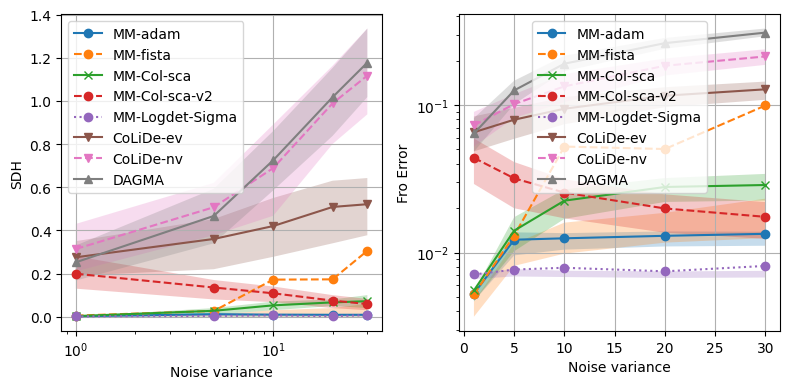

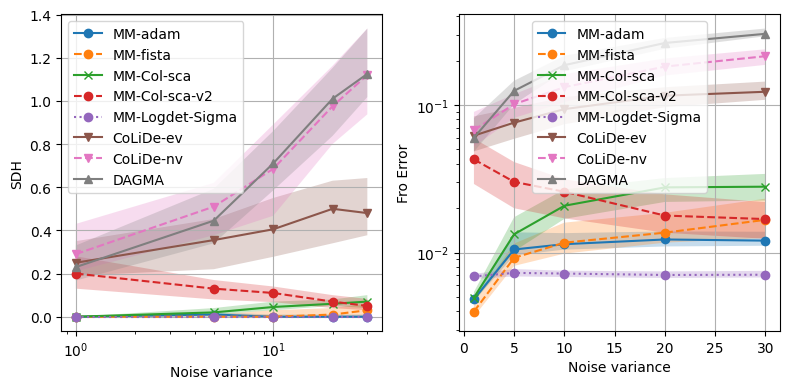

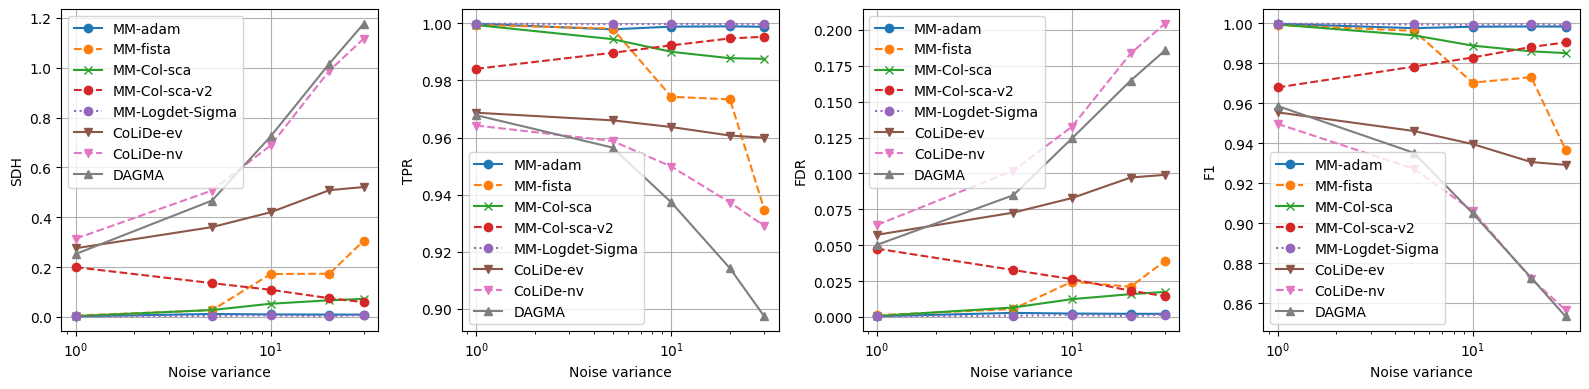

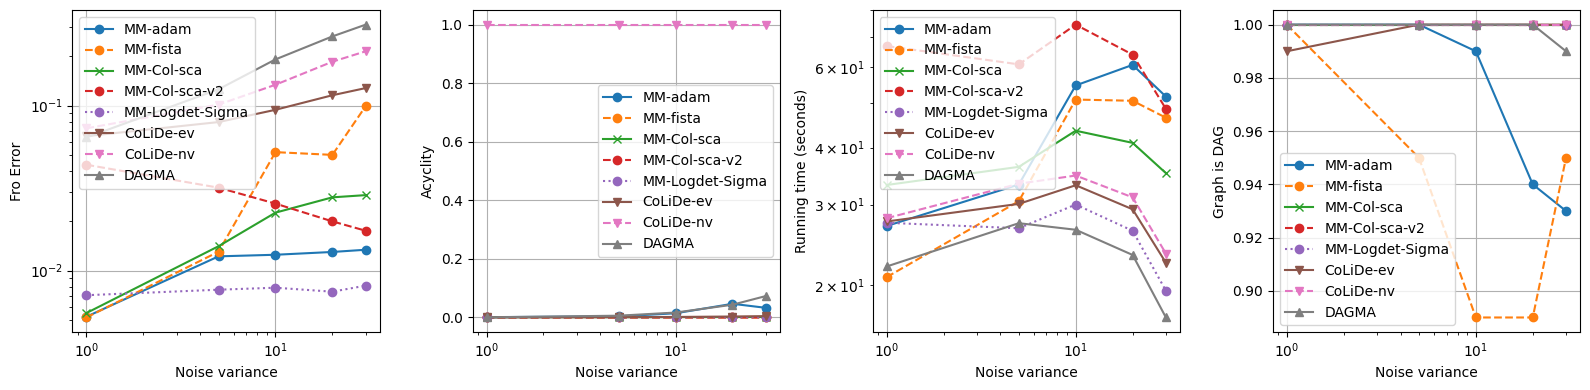

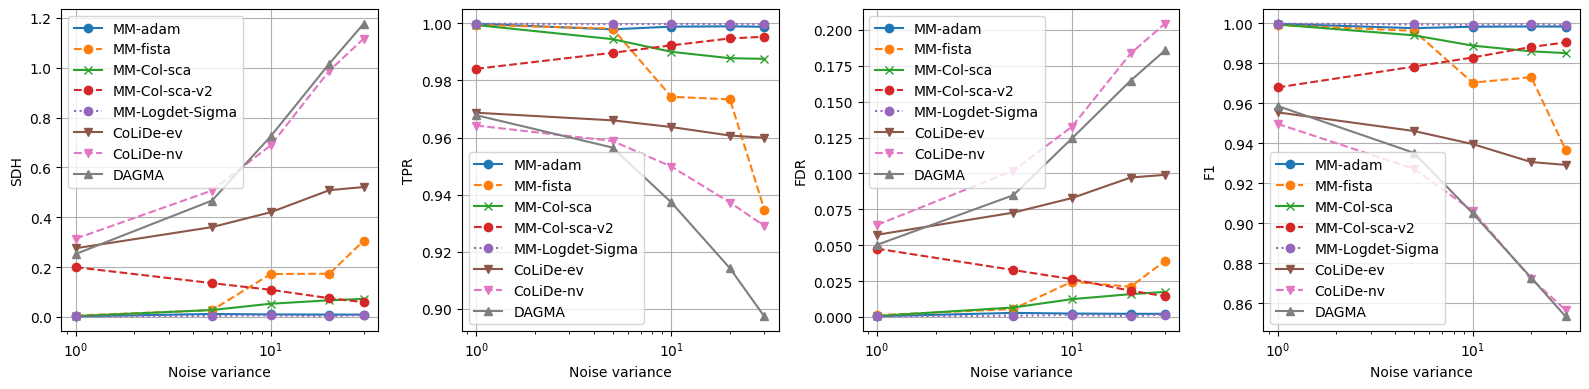

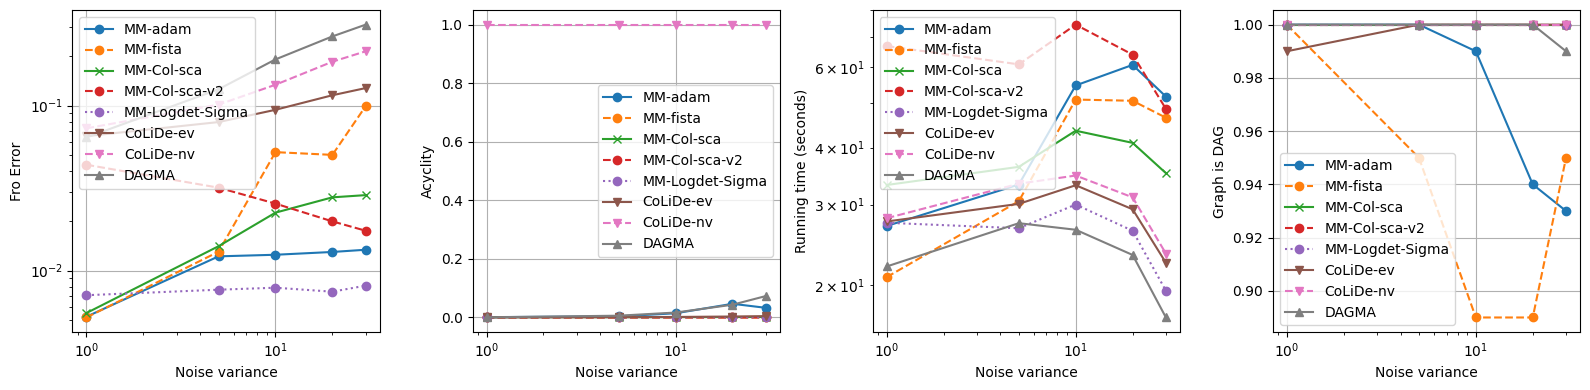

In [6]:
if SAVE:
    vars = np.array(vars)
    file_name = PATH + f'var_ERgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=vars)
    print('SAVED in file:', file_name)

    agg_error = np.median(err, axis=0)
    utils.data_to_csv(f'{PATH}vars_err_med.csv', Exps, vars, agg_error)
    prctile25 = np.percentile(err, 25, axis=0)
    utils.data_to_csv(f'{PATH}vars_err_prctile25.csv', Exps, vars, prctile25)
    prctile75 = np.percentile(err, 75, axis=0)
    utils.data_to_csv(f'{PATH}vars_err_prctile75.csv', Exps, vars, prctile75)

    agg_shd = np.mean(err, axis=0)
    utils.data_to_csv(f'{PATH}vars_shd_mean.csv', Exps, vars, agg_shd)
    std_shd = np.std(err, axis=0)
    utils.data_to_csv(f'{PATH}vars_shd_std.csv', Exps, vars, std_shd)

skip = [] # [2]

# Plot Mean
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
utils.plot_data(axes[0], shd, Exps, vars, 'Noise variance', 'SDH', skip,
                agg='mean', deviation='prctile', alpha=0.25)
utils.plot_data(axes[1], err, Exps, vars, 'Noise variance', 'Fro Error', skip,
                agg='mean', deviation='prctile', alpha=0.25, plot_func='semilogy')
plt.tight_layout()

# Plot Median
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
utils.plot_data(axes[0], shd, Exps, vars, 'Noise variance', 'SDH', skip,
                agg='median', deviation='prctile', alpha=0.25)
utils.plot_data(axes[1], err, Exps, vars, 'Noise variance', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='semilogy')
plt.tight_layout()

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, vars, Exps,
                 skip_idx=skip, agg='mean', xlabel='Noise variance')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, vars, Exps,
                 skip_idx=skip, agg='mean', xlabel='Noise variance')

In [7]:
# Load Data
# file_name = "./results/var/var_ERgraph_4N.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps = data['exps']
# shd = data['shd']
# fdr = data['fdr']
# fscore = data['fscore']
# err = data['err']
# acyc = data['acyc']
# runtime = data['runtime']
# dag_count = data['dag_count']
# tpr = data['tpr']
# vars = data['xvals']